[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!pip install -U --no-cache-dir gdown --pre

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

Downloading...
From: https://drive.google.com/uc?id=1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK
To: /Users/yvesgreatti/github/2023-Experiments/data.tar.gz
100%|██████████| 1.31G/1.31G [00:16<00:00, 77.7MB/s]


In [23]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage i.e. 90%

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [34]:
idx

array([False, False, False, ..., False, False, False])

### Conformalized Quantile Regression

1. Perform a permutation of $\{\pi_1(x), \cdots, \pi_k(x)\}$ that sort the scores from most likely to least likely.
2. The score is defined as $s(x,y) = \sum_{i=1}^k \hat{f(x)}_{\pi_i}$ where $y = \pi_k(x)$
3.  Prediction sets: $\{y: s(x,y) \le \hat{q}\}$ where $\hat{q} = \text{Quantile}(s_1,\cdots,s_n; \frac{(n+1)(1-\alpha}{n} )$

In [45]:
# Get scores. 
cal_pi = cal_smx.argsort(1)[:,::-1]
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),cal_labels]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_19194/2705633753.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


In [46]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9112653061224489


The supremum of the prediction set is $\widehat{f(x_i)} > 1-\hat{q}$

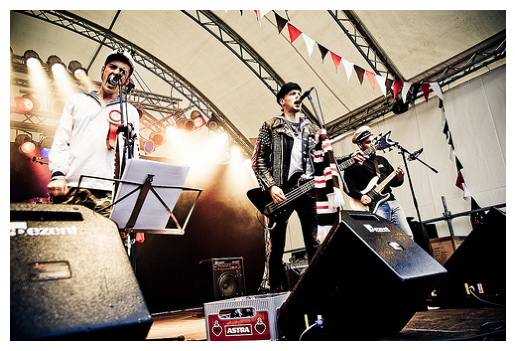

The prediction set is: ['accordion', 'acoustic guitar', 'banjo', 'bassoon', 'bookstore', 'breastplate', 'cello', 'chain mail', 'cornet', 'drum', 'drumstick', 'electric guitar', 'flute', 'French horn', 'grand piano', 'greenhouse', 'harmonica', 'jeans', 'microphone', 'military uniform', 'notebook computer', 'oboe', 'plectrum', 'saxophone', 'shield', 'spotlight', 'stage', 'toy store', 'trombone', 'violin', 'comic book']


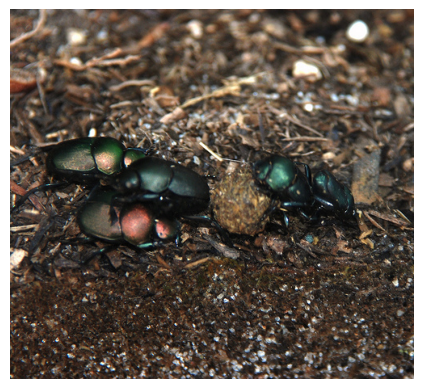

The prediction set is: ['scorpion', 'tiger beetle', 'ground beetle', 'leaf beetle', 'dung beetle', 'rhinoceros beetle', 'fly', 'ant']


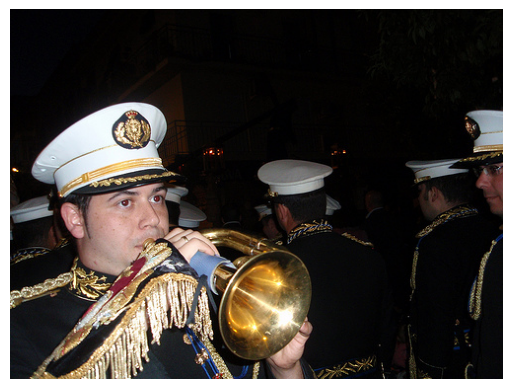

The prediction set is: ['accordion', 'cornet', 'drum', 'flute', 'French horn', 'oboe', 'pan flute', 'saxophone', 'trombone']


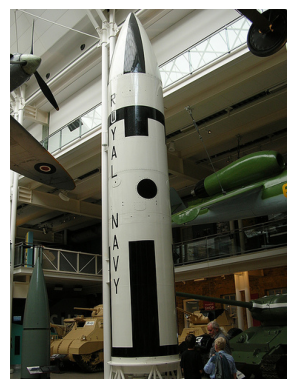

The prediction set is: ['missile', 'projectile']


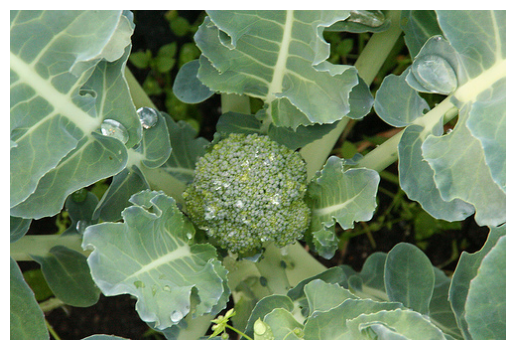

The prediction set is: ['cabbage', 'broccoli', 'cauliflower']


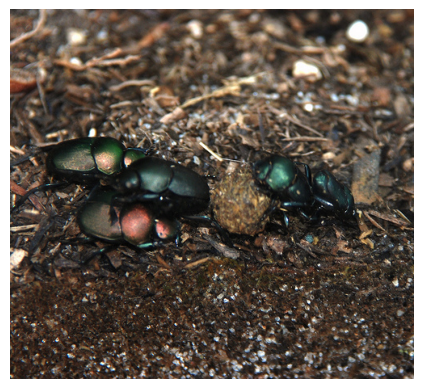

The prediction set is: ['scorpion', 'tiger beetle', 'ground beetle', 'leaf beetle', 'dung beetle', 'rhinoceros beetle', 'fly', 'ant']


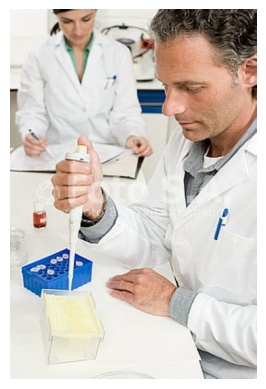

The prediction set is: ['beaker', 'lab coat', 'stethoscope']


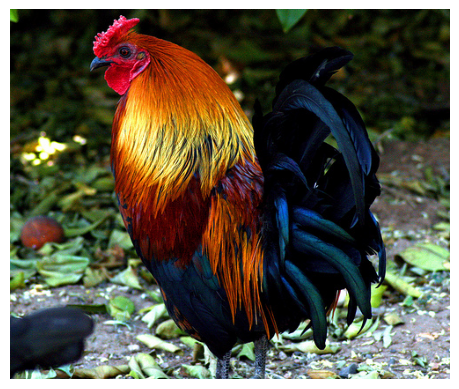

The prediction set is: ['cock', 'hen', 'partridge', 'macaw', 'lorikeet', 'flamingo', 'crane (bird)', 'guinea pig', 'marmoset', 'stinkhorn mushroom']


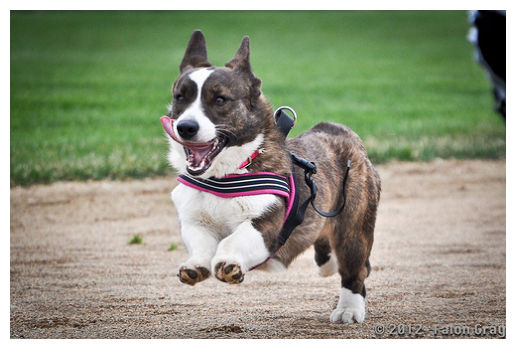

The prediction set is: ['toy terrier', 'Staffordshire Bull Terrier', 'American Staffordshire Terrier', 'Norwich Terrier', 'Australian Terrier', 'Boston Terrier', 'Australian Kelpie', 'collie', 'Border Collie', 'Bullmastiff', 'French Bulldog', 'husky', 'Basenji', 'Pembroke Welsh Corgi', 'Cardigan Welsh Corgi', 'lens cap', 'ping-pong ball', 'rugby ball', 'soccer ball', 'tennis ball', 'water bottle']


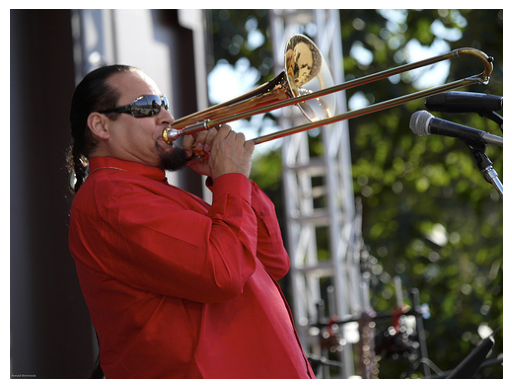

The prediction set is: ['cornet', 'trombone']


In [48]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")